<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/20__translator_seq2seq_wordLevel_06122023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항|	상세기준|내 평가|
|--|--|--|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	|구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|o|
|2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.|	seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.|o|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	|테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.|o|

# Get Data

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking, Dropout
from tensorflow.keras.models import Model

In [ ]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수:', len(lines))
lines.sample(5)

전체 샘플의 수: 217975


,eng,fra,cc
151610,Last night we worked until 10 p.m.,Hier soir nous avons travaillé jusqu'à dix heu...,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
207965,It's very likely that somebody will be waiting...,Il est très probable que quelqu'un sera en tra...,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
133360,Tom told me that Mary was dead.,Tom m'a dit que Marie était morte.,CC-BY 2.0 (France) Attribution: tatoeba.org #6...
61645,He spoke highly of you.,Il a été dithyrambique à votre sujet.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
6974,Bring a lunch.,Apporte à déjeuner !,CC-BY 2.0 (France) Attribution: tatoeba.org #4...


In [ ]:
lines = lines[['eng', 'fra']][60000:93000]
lines.sample(5)

,eng,fra
87653,I haven't lost any weight.,Je n'ai pas perdu de poids.
64848,Please give him a call.,"Veuillez lui téléphoner, je vous prie."
67215,What do you make of it?,Qu'est ce que tu en penses ?
61696,He was shorter than me.,Il était plus petit que moi.
84239,Where did you learn that?,Où as-tu appris ça ?


In [ ]:
lines_np_eng= lines['eng'].to_numpy()
lines_np_fra= lines['fra'].to_numpy()
lines_np_eng

array(['You were there, right?', 'You will stay at home.',
       "You won't be punished.", ..., 'What time did you wake up?',
       'What time did you wake up?', 'What time did you wake up?'],
      dtype=object)

# 1 Refine, normalize, preprocess

In [ ]:
sos_token = '<start> '
eos_token = ' <end>'

def preprocess_line(line, plus_token = True):
    # 소문자로 변경하기
    line = line.lower().strip()
    # 구두점(Punctuation)을 단어와 분리하기
    line = re.sub(r"([?.!,¿])", r" \1 ", line)
    line = re.sub(r'[" "]+', " ", line)
    line = re.sub(r"[^a-zA-Z?.!,¿]+", " ", line)

    line = line.strip()

    if plus_token == True:
        line = sos_token + line + eos_token

    return line

## Tokenize

In [ ]:
def tokenize(corpus):
    tokenizer = Tokenizer(
        num_words=7000,
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    return tensor, tokenizer

In [ ]:
eng_lines = []
fra_lines = []

# eng_lines.append(lines.eng.apply(lambda x : preprocess_line(x,plus_token = False)))
# fra_lines.append(lines.fra.apply(lambda x : preprocess_line(x),))

for eng, fra in zip(lines.eng, lines.fra):
    if len(eng) == 0: continue
    if len(fra) == 0: continue

    eng_lines.append(preprocess_line(eng, plus_token = False))
    fra_lines.append(preprocess_line(fra))

In [ ]:
np.shape(eng_lines)

(33000,)

In [ ]:
eng_tensor, eng_tokenizer = tokenize(eng_lines)
fra_tensor, fra_tokenizer = tokenize(fra_lines)
fra_tensor[:10]

[[2, 15, 105, 23, 374, 34, 19, 7, 22, 8, 6, 3],
 [2, 15, 3036, 151, 78, 4, 3],
 [2, 15, 13, 1135, 8, 3723, 4, 3],
 [2, 10, 19, 347, 8, 16, 1519, 4, 3],
 [2, 15, 13, 389, 8, 16, 1519, 4, 3],
 [2, 10, 19, 1647, 8, 17, 4, 3],
 [2, 15, 443, 176, 9, 5098, 4, 3],
 [2, 15, 443, 176, 9, 35, 20, 128, 278, 4, 3],
 [2, 15, 443, 176, 9, 26, 841, 72, 4, 3],
 [2, 10, 1136, 176, 9, 10, 841, 72, 4, 3]]

In [ ]:
eng_tensor[:10]

[[4, 61, 53, 43, 88, 5],
 [4, 78, 144, 48, 101, 2],
 [4, 108, 7, 31, 1650, 2],
 [4, 108, 7, 630, 16, 2],
 [4, 108, 7, 630, 16, 2],
 [4, 481, 7, 35, 11, 2],
 [4, 76, 141, 121, 147, 2],
 [4, 76, 141, 404, 72, 2],
 [4, 76, 141, 427, 49, 2],
 [4, 76, 141, 427, 49, 2]]

In [ ]:
encoder_input = eng_tensor
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index['<end>']] for line in fra_tensor]
# 시작 토큰 제거
decoder_target =[[char for char in line if char != fra_tokenizer.word_index['<start>']] for line in fra_tensor]

## padding

In [ ]:
def pad_tensor(tensor):
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = max(num_tokens)
#     max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    tensor = pad_sequences(tensor, padding='post', maxlen=maxlen)
    return tensor

In [ ]:
encoder_input = pad_tensor(encoder_input)
decoder_input = pad_tensor(decoder_input)
decoder_target = pad_tensor(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 10)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index)+1
fra_vocab_size = len(fra_tokenizer.word_index)+1

max_eng_seq_len = encoder_input.shape[1]
max_fra_seq_len = decoder_input.shape[1]

In [ ]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 5795
프랑스어 단어장의 크기 : 8297
영어 시퀀스의 최대 길이 10
프랑스어 시퀀스의 최대 길이 17


## Split

In [ ]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 10)
(30000, 17)
(30000, 17)
(3000, 10)
(3000, 17)
(3000, 17)


# Get Train Model with Embedding layer
https://wikidocs.net/33793

## Encoder

In [ ]:
embedding_size = 512
hidden_size = 512

encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)

encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

encoder_states = [state_h, state_c]

## Decoder

In [ ]:
decoder_inputs = Input(shape=(None, ), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)

decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)

In [ ]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Join Train Model

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2967040     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 512)    4248064     decoder_input[0][0]              
______________________________________________________________________________________________

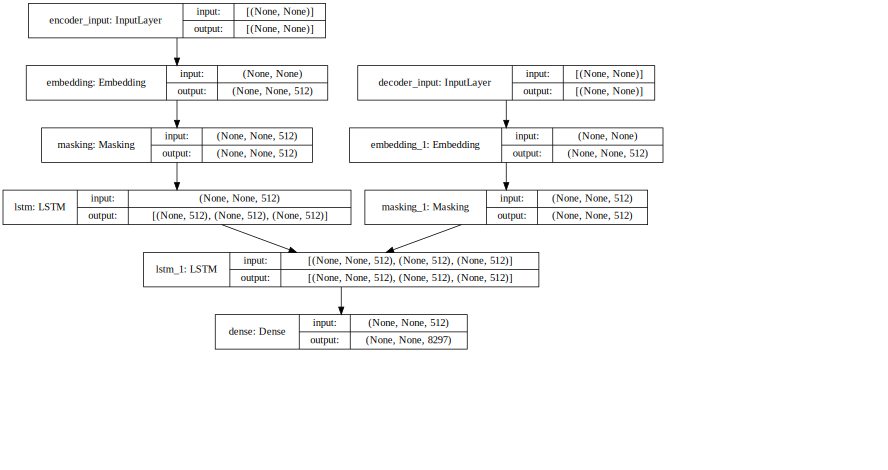

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=96).create(prog='dot', format='svg'))

## Train

In [ ]:
import tensorflow as tf

# rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0003)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

history = model.fit(x=[encoder_input_train, decoder_input_train],
          y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test],
                             decoder_target_test),
          batch_size=32,
          epochs=50)

Epoch 1/50
938/938 [==============================] - 28s 21ms/step - loss: 1.9296 - val_loss: 1.5871
Epoch 2/50
938/938 [==============================] - 18s 19ms/step - loss: 1.4644 - val_loss: 1.3733
Epoch 3/50
938/938 [==============================] - 18s 19ms/step - loss: 1.2742 - val_loss: 1.2450
Epoch 4/50
938/938 [==============================] - 18s 19ms/step - loss: 1.1391 - val_loss: 1.1623
Epoch 5/50
938/938 [==============================] - 18s 19ms/step - loss: 1.0364 - val_loss: 1.0946
Epoch 6/50
938/938 [==============================] - 18s 19ms/step - loss: 0.9576 - val_loss: 1.0519
Epoch 7/50
938/938 [==============================] - 18s 19ms/step - loss: 0.8889 - val_loss: 1.0242
Epoch 8/50
938/938 [==============================] - 18s 19ms/step - loss: 0.8396 - val_loss: 1.0118
Epoch 9/50
938/938 [==============================] - 18s 19ms/step - loss: 0.7980 - val_loss: 0.9990
Epoch 10/50
938/938 [==============================] - 18s 19ms/step - loss: 0.765

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


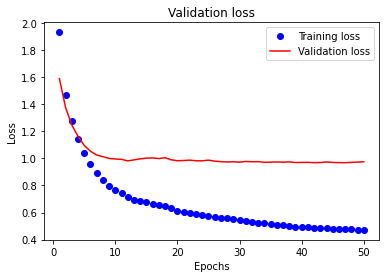

In [ ]:
# padding : post, with masking layer
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model

model.save('translator_model_50.h5')

# Evaluate

In [ ]:
from keras.models import load_model
model = load_model('translator_model_50.h5')

## Get Inference Model

### Encoder

In [ ]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         2967040   
_________________________________________________________________
masking (Masking)            (None, None, 512)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 2099200   
Total params: 5,066,240
Trainable params: 5,066,240
Non-trainable params: 0
_________________________________________________________________


### Decoder

In [ ]:
decoder_state_input_h = Input(shape=(embedding_size,))
decoder_state_input_c = Input(shape=(embedding_size,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

decoder_outputs2 = decoder_softmax_layer(decoder_outputs2)

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [ ]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 512)    4248064     decoder_input[0][0]              
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
____________________________________________________________________________________________

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <start>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<start>']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<end>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

In [ ]:
# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<start>']) and i!=fra2idx['<end>']):
            temp = temp + idx2fra[i] + ' '
    return temp

## test Model

In [ ]:
for seq_index in [10, 100, 1000, 1500, 2300]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', seq2src(encoder_input_test[seq_index]))
    print('정답 문장:', seq2tar(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장: nobody knows it but me . 
정답 문장: personne ne le sait , part moi . 
번역기가 번역한 문장:  personne ne ne n
-----------------------------------
입력 문장: which browser do you use ? 
정답 문장: quel navigateur utilisez vous ? 
번역기가 번역한 문장:  quel <unk> vous 
-----------------------------------
입력 문장: he is inclined to get mad . 
정답 문장: il a tendance se mettre en col re . 
번역기가 번역한 문장:  il est de le se 
-----------------------------------
입력 문장: i have the ace of spades . 
정답 문장: j ai l as de pique . 
번역기가 번역한 문장:  j en la l au d . 
-----------------------------------
입력 문장: maybe i drink too much . 
정답 문장: je bois peut tre trop . 
번역기가 번역한 문장:  peut tre peut qu


# Result

-----------------------------------
입력 문장: nobody knows it but me .
정답 문장: personne ne le sait , part moi .
번역기가 번역한 문장:  personne ne ne n
파파고가 번역한 문장 : 무인
-----------------------------------
입력 문장: which browser do you use ?
정답 문장: quel navigateur utilisez vous ?
번역기가 번역한 문장:  quel <unk> vous
파파고가 번역한 문장 : 당신이 어떤 <unk>를
-----------------------------------
입력 문장: he is inclined to get mad .
정답 문장: il a tendance se mettre en col re .
번역기가 번역한 문장:  il est de le se
파파고가 번역한 문장 : 그 사람은 게으름뱅이
-----------------------------------
입력 문장: i have the ace of spades .
정답 문장: j ai l as de pique .
번역기가 번역한 문장:  j en la l au d .
파파고가 번역한 문장 : 지긋지긋하다
-----------------------------------
입력 문장: maybe i drink too much .
정답 문장: je bois peut tre trop .
번역기가 번역한 문장:  peut tre peut qu
파파고가 번역한 문장 : -ㄹ지 모른다

# Review
- 패딩을 pre로 할 경우 모델에서 masking layer가 필요없었지만, post로 할 경우 masking layer가 필요했음
    패딩이 pre일 때 masking layer 없으면 에러.
    masking layer의 역할 : 입력 시퀀스의 일부를 랜덤하게 마스크하여 모델이 해당 부분을 예측하도록 유도 빈칸을 채우거나 문장 생성과 같은 작업을 수행. 문맥을 파악하고 다응ㅁ에 나올 단어나 토큰을 예측할 수 있음.(https://huyntohoon.tistory.com/14)
- 문장 330000를 가지고 여러 시도를 해보았지만(토큰화 방법, dropout 비율, 학습율, 패팅 방법, 문장의 길이 등을 변경하여 학습한 성능이 val loss 기준으로 1.1~ 1.4이었고 번역한 문장은 영어 첫 단어가 같은 모든 같은 단어로 시작하는 프랑스 문장으로 번역됨.
- 학습할 문장을 53000개로 늘렸더니 val loss가 0.8로 상당히 성능 향상이라고 기대했지만 번역된 결과는 앞선 학습과 다르지 않음.
- 배치 사이즈를 줄여 학습하였더니 val loss의 개선이 크지 않았지만 번역에서는 조금 나은 결과를 얻었음.
- 번역한 내용이 완벽하게 정확하지는 않지만 의미가 통하는 번역을 얻었음.
- 모델 구조가 복잡하고 성능을 향상시킬 수 있는 변수가 많아 더 많은 학습이 필요하겠음.

https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639